# 環境の説明
```
conda create -n LLMfromScratch python

conda activate LLMfromScratch
```
ここからpipを使ってインストールする

インストールしたもの

`pip install tiktoken`

`pip install torch`

# テキストデータの読み込み

urllibを使ってtxtデータに変換する

In [1]:
!pwd

/Users/kakuayato/Documents/GitHub/CurioSync_LLM/public/llm


In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

GPTバックボーンの作成

In [3]:
import torch 
import torch.nn as nn

class DummyGPTModel(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            #　ここはただただ入力値をtrfのブロック一つ一つに適応していくだけ
            *[DummyTransformerBlock(cfg) for  _ in range(cfg["n_layers"])]
        )

        self.final_norm = DummyLayerNorm(cfg["emb_dim"]) # 正規化するだけ
        self.out_head = nn.Linear(
            # 行列の形を整える＋softmaxを入れて確率分布にしている
            cfg["emb_dim"], cfg["vocab_size"], bias= False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
            # これはpos_idsをまず作成し，その番号にあったemd行列を割り振る必要があるから
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
    
class DummyTransformerBlock(nn.Module):

    def __init__(self, cfg):
        super().__init__()
    
    def forward(self, x):
        return x

class DummyLayerNorm(nn.Module):

    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
    
    def forward(self, x):
        return x


In [4]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [5]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output_shape:" ,logits.shape)
print("Output: ", logits)

Output_shape: torch.Size([2, 4, 50257])
Output:  tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


層正規化の実装

In [6]:
torch.manual_seed(123)
batch_example = torch.randn(2,5)
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [7]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("mean: ", mean)
print("var: ",var)

mean:  tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
var:  tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [8]:
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer outputs:\n" ,out_norm)

mean_2 = out_norm.mean(dim=-1, keepdim=True)
var_2 = out_norm.var(dim=-1, keepdim=True)
print("mean: ", mean_2)
print("var: ",var_2)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
mean:  tensor([[-5.9605e-08],
        [ 1.9868e-08]], grad_fn=<MeanBackward1>)
var:  tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


classの定義

In [9]:
class LayerNorm(nn.Module):
    def __init__(self,emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift



In [10]:
ln = LayerNorm(emb_dim = 5)
out_ln = ln(batch_example)
mean_3 = out_ln.mean(dim=-1, keepdim=True)
var_3 = out_ln.var(dim=-1, keepdim=True, unbiased=False)
print("mean", mean_3)
print("var", var_3)

mean tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
var tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


# GELU活性化を使ってフィードフォワードネットワークを実装する

In [11]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,x):
        return 0.5 * x * (1 + torch.tanh( 
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.44715 * torch.pow(x,3))
            ))

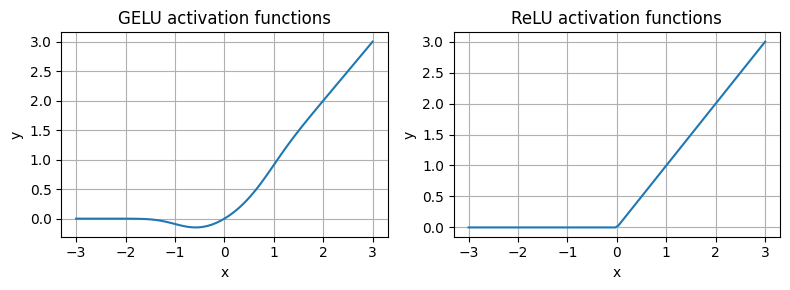

In [12]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3,3,100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize =(8,3))

for i, (y, label) in enumerate(zip([y_gelu,y_relu], ["GELU", "ReLU"]),1):
    plt.subplot(1,2,i) # これで一つの画像を二つに分解しているらしい（iはどっちに書くか見たいな）
    plt.plot(x,y)
    plt.title(F"{label} activation functions")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [13]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]),
            GELU(),
            nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"]),
        )
    
    def forward(self,x):
        return self.layers(x)

# ショートカット接続の実装

In [14]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.user_shortcut = use_shortcut

        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]),GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]),GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]),GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]),GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]),GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.user_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

In [15]:
layer_sizes = [3,3,3,3,3,1]
sample_input = torch.tensor([[1.,0.,-1.]])



model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)

In [16]:
def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss = loss(output,target)

    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of "
                  f"{param.grad.abs().mean().item()}")
            

In [17]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00022910122061148286
layers.1.0.weight has gradient mean of 0.00032500529778189957
layers.2.0.weight has gradient mean of 0.0010107634589076042
layers.3.0.weight has gradient mean of 0.006122054066509008
layers.4.0.weight has gradient mean of 0.06471908092498779


In [18]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.29920274019241333
layers.1.0.weight has gradient mean of 0.2749510407447815
layers.2.0.weight has gradient mean of 0.454661101102829
layers.3.0.weight has gradient mean of 0.3629586398601532
layers.4.0.weight has gradient mean of 1.763088583946228


# TransformerブロックでAttention層と線形層を接続する

In [19]:
class MultiHeadAttention(nn.Module):
    def __init__(self,d_in,d_out,context_length,dropout_rate, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in,d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in,d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in,d_out, bias= qkv_bias)

        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout_rate)
        self.register_buffer(
            'mask',
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1,2)
        queries = queries.transpose(1,2)
        values = values.transpose(1,2)

        attn_scores = queries @ keys.transpose(2,3)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill(mask_bool, -torch.inf)
                                
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]** 0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1,2)
        context_vec = context_vec.contiguous().view(
            b, num_tokens, self.d_out
        )
        context_vec = self.out_proj(context_vec)

        return context_vec


In [20]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            dropout_rate=cfg["drop_rate"],
            num_heads=cfg["n_heads"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
    
    def forward(self, x):
        
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x

In [21]:
torch.manual_seed(123)
x = torch.rand(2,4,768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


# GPT2の実装

In [22]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
    
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)

        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)

        return logits


In [23]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

print("config: \n", GPT_CONFIG_124M)
print("batch: \n", batch)
out = model(batch)
print("out: \n", out)

print("input_shape: ", batch.shape)
print("output_shape: ", out.shape)


config: 
 {'vocab_size': 50257, 'context_length': 1024, 'emb_dim': 768, 'n_heads': 12, 'n_layers': 12, 'drop_rate': 0.1, 'qkv_bias': False}
batch: 
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
out: 
 tensor([[[ 0.3680, -0.0512, -0.2017,  ...,  0.3796,  0.0994, -0.1771],
         [ 0.3056, -0.6867, -0.9142,  ..., -0.2566,  0.2698, -0.2660],
         [ 0.9968,  0.0474, -0.3311,  ...,  0.0242, -0.4969, -0.1374],
         [-0.9144,  0.5091, -0.2184,  ...,  0.6625,  0.3697,  0.1258]],

        [[-0.5439, -0.2650, -0.0717,  ...,  0.2004,  0.1287, -0.3478],
         [ 0.2217,  0.4015, -0.1623,  ...,  0.6635, -0.0920,  0.4626],
         [ 1.1449,  0.7195, -0.1851,  ...,  0.8189,  0.1938, -0.2751],
         [-0.1554,  0.5992,  0.2413,  ...,  1.2204, -0.2179, -0.0131]]],
       grad_fn=<UnsafeViewBackward0>)
input_shape:  torch.Size([2, 4])
output_shape:  torch.Size([2, 4, 50257])


In [24]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Tortal number of parameters: {total_params:,}")

Tortal number of parameters: 163,009,536


# テキストを生成する

In [25]:
def generate_text_sample(model, idx, max_new_tokens, context_size):

    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        
        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
    
    return idx

In [26]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape: ", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape:  torch.Size([1, 4])


In [27]:
model.eval()

out = generate_text_sample(
    model=model,
    idx = encoded_tensor,
    max_new_tokens=6,
    context_size= GPT_CONFIG_124M["context_length"]

)
print("out: ",out)

out:  tensor([[15496,    11,   314,   716, 27018,  7283, 46275, 41426,   484, 29248]])


In [28]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Feature IT snowballProtect they stereotyp


# 練習問題4-1

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params: ,}")

Total number of parameters:  163,009,536


model.parametersの中身はなんだろ

In [34]:
i = 0
for p in model.parameters():
    i = i +1
print(i)

161


In [35]:
ff_model = FeedForward(GPT_CONFIG_124M)
ff_model_parameter_sum = sum(p.numel() for p in ff_model.parameters())
print(ff_model_parameter_sum)

4722432


In [36]:
cfg = GPT_CONFIG_124M
att_model = MultiHeadAttention(
    d_in=cfg["emb_dim"],
    d_out=cfg["emb_dim"],
    context_length=cfg["context_length"],
    dropout_rate=cfg["drop_rate"],
    num_heads=cfg["n_heads"],
    qkv_bias=cfg["qkv_bias"]
)
att_model_parameter_sum = sum(p.numel() for p in att_model.parameters())
print(att_model_parameter_sum)

2360064


In [38]:
block = TransformerBlock(GPT_CONFIG_124M)

block_ff_model_parameter_sum = sum(p.numel() for p in block.ff.parameters())
block_att_model_parameter_sum = sum(p.numel() for p in block.att.parameters())

print(block_ff_model_parameter_sum)
print(block_att_model_parameter_sum)

4722432
2360064


# 練習問題4-2

In [42]:
def print_sum_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total number of parameters: {total_params: ,}")

In [43]:
gpt2_medium = GPTModel(
    {
        "vocab_size": 50257,
        "context_length": 1024,
        "emb_dim": 1024,
        "n_heads": 16,
        "n_layers": 24,
        "drop_rate": 0.1,
        "qkv_bias": False
    }
)

gpt2_large = GPTModel(
    {
        "vocab_size": 50257,
        "context_length": 1024,
        "emb_dim": 1280,
        "n_heads": 20,
        "n_layers": 36,
        "drop_rate": 0.1,
        "qkv_bias": False
    }
)

gpt2_XL = GPTModel(
    {
        "vocab_size": 50257,
        "context_length": 1024,
        "emb_dim": 1600,
        "n_heads": 25,
        "n_layers": 48,
        "drop_rate": 0.1,
        "qkv_bias": False
    }
)

In [44]:
print_sum_parameters(gpt2_medium)
print_sum_parameters(gpt2_large)
print_sum_parameters(gpt2_XL)

Total number of parameters:  406,212,608
Total number of parameters:  838,220,800
Total number of parameters:  1,637,792,000


# 練習問題4-3